# Fetching data from the Dataset

## Importing libraries

In [1]:
# ! pip install standard-transform
# ! pip install caveclient --upgrade

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from caveclient import CAVEclient
import matplotlib.pyplot as plt
from microns_phase3 import nda
from standard_transform import minnie_transform_vx

Connecting microns@db.datajoint.com:3306


Could not create the ~log table
Could not access table `microns_phase3_nda`.`~log`


In [3]:
tform_vx = minnie_transform_vx()

## Query data

In [4]:
client = CAVEclient()

In [5]:
# client.auth.get_new_token()

In [6]:
#client.auth.save_token("64ea0271652fd86dc7fb6376cd9d52b9")

In [7]:
client = CAVEclient('minnie65_public_v343')

In [8]:
client.materialize.get_tables()

['synapses_pni_2',
 'nucleus_neuron_svm',
 'nucleus_detection_v0',
 'functional_coreg',
 'allen_v1_column_types_slanted',
 'aibs_column_nonneuronal',
 'func_unit_em_match_release',
 'proofreading_status_public_release',
 'aibs_soma_nuc_metamodel_preds_v117']

## Filtering data

In [9]:
df = client.materialize.query_table('functional_coreg')
df.set_index('pt_root_id', inplace=True)

In [10]:
df.head()

,id,valid,pt_supervoxel_id,session,scan_idx,unit_id,pt_position
pt_root_id,,,,,,,
864691136136642173,1,t,102531727972419182,4,7,665,"[274864, 94064, 22046]"
864691136208993724,2,t,94792540099826672,4,7,740,"[218320, 104320, 19016]"
864691135683934135,4,t,93946810036875732,4,7,782,"[212128, 94544, 23423]"
864691135334528233,5,t,84730565597057981,4,7,855,"[145158, 110036, 19355]"
864691136309730650,6,t,110905058841147285,4,7,921,"[335744, 90128, 22805]"


In [31]:
df.shape

(9518, 7)

In [11]:
root_ids = df.index.tolist()

In [22]:
len(root_ids)/10*140

133252.0

In [12]:
subset_ids = root_ids[:10]

In [13]:
x_values = []
y_values = []
for i in subset_ids:
    input_df = client.materialize.synapse_query(post_ids=i)
    
    input_df.rename(columns = {'pre_pt_root_id':'pt_root_id'}, inplace = True) 
   
    df_functional_matched = pd.merge(input_df,df,on='pt_root_id',how='inner')
    if df_functional_matched.empty:
        continue
        
    #This is the correct depth value that is retrieved by a special function created by the MICrONS team    
    input_vertices_list = tform_vx.apply(df_functional_matched['pt_position'])
    graph_x_stack = np.vstack(input_vertices_list)
    graph_x_values = graph_x_stack[:,1]

    output_vertices = tform_vx.apply(df.at[i,'pt_position'])
    graph_y_value = output_vertices[1]
    if type(graph_y_value) != np.float64:
        continue
    
    num_points = len(graph_x_values)
    x_values.extend(graph_x_values)
    y_values.extend([graph_y_value]*num_points)
    

In [14]:
f_export = pd.DataFrame(list(zip(x_values, y_values)),
               columns =['X Values', 'Y Values'])

In [19]:
f_export.shape

(140, 2)

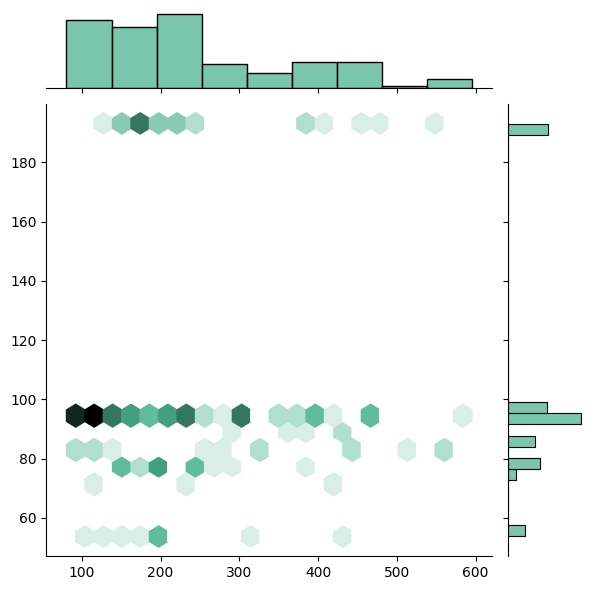

In [16]:
sns.jointplot(x=x_values, y=y_values, kind="hex", color="#4CB391")